## (a) Importing libraries

In [133]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras_tuner import RandomSearch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import visualkeras
from keras.utils import plot_model
import pydotplus

## (b) Data loading and preparation

In [134]:
# load datasets
white_wine = pd.read_csv('winequality-white.csv', sep=';')
red_wine = pd.read_csv('winequality-red.csv', sep=';')

In [135]:
# assign labels
white_wine['type'] = 'white'
red_wine['type'] = 'red'

In [136]:
# merge datasets
wine = pd.concat([white_wine, red_wine])

In [137]:
# encode labels
wine['type'] = wine['type'].map({'white': 0, 'red': 1})

In [138]:
#remove duplicate values
wine.drop_duplicates(inplace=True)

In [139]:
#Identify the skewness and outliers
skewness = wine.skew()
Q1 = wine.quantile(0.25)
Q3 = wine.quantile(0.75)
IQR = Q3 - Q1
outliers = ((wine < (Q1 - 1.5 * IQR)) | (wine > (Q3 + 1.5 * IQR))).any(axis=1)

In [140]:
# Remove outliers
wine = wine[~outliers]

In [141]:
# split features and labels
X = wine.drop('type', axis=1)
y = wine['type']

In [142]:
# normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [143]:
# split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [144]:
print(X_train)

[[-1.0695713  -1.11623515  1.58163642 ... -0.76946429 -0.68084633
   0.2688715 ]
 [ 2.93412666  0.86246159  0.37436845 ...  1.31052937  0.43771569
   0.2688715 ]
 [-0.06864681 -0.79964367  2.70267098 ...  0.70386455 -0.3366734
   0.2688715 ]
 ...
 [-0.62471597 -0.08731284  0.63306873 ... -1.2027963  -1.36919218
  -1.02202804]
 [ 0.26499468  2.52456686 -2.6438015  ...  0.61719815 -1.36919218
   0.2688715 ]
 [ 0.37620852 -0.24560858  0.5468353  ...  0.96386376  0.17958599
  -1.02202804]]


## (c) Model development
- Design, train and evaluate neural network models
- Designed 5 different neural network architectures to be trained

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_240 (Dense)           (None, 64)                832       
                                                                 
 dense_241 (Dense)           (None, 1)                 65        
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


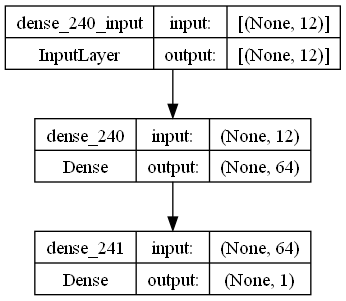

In [145]:
# Model 1
# Two dense layers (one hidden layer)
model1 = Sequential()
model1.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model1.add(Dense(1, activation='sigmoid'))

model1.summary()
plot_model(model1, to_file='model_architecture1.png', show_shapes=True)

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_242 (Dense)           (None, 64)                832       
                                                                 
 dense_243 (Dense)           (None, 32)                2080      
                                                                 
 dense_244 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


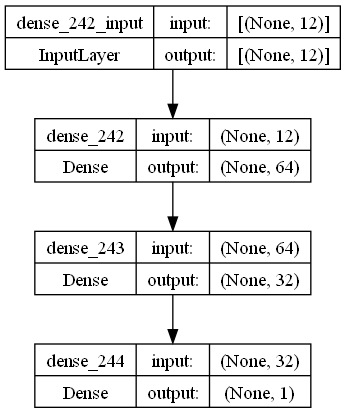

In [146]:
# Model 2
# Three dense layers (two hidden layers)
model2 = Sequential()
model2.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.summary()
plot_model(model2, to_file='model_architecture2.png', show_shapes=True)

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_245 (Dense)           (None, 64)                832       
                                                                 
 dense_246 (Dense)           (None, 64)                4160      
                                                                 
 dense_247 (Dense)           (None, 32)                2080      
                                                                 
 dense_248 (Dense)           (None, 1)                 33        
                                                                 
Total params: 7,105
Trainable params: 7,105
Non-trainable params: 0
_________________________________________________________________


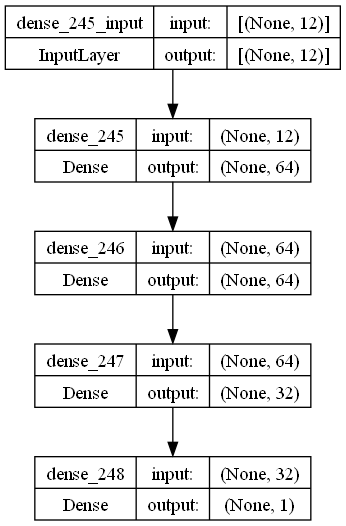

In [147]:
# Model 3
# Four dense layers (three hidden layers)
model3 = Sequential()
model3.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.summary()
plot_model(model3, to_file='model_architecture3.png', show_shapes=True)

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_249 (Dense)           (None, 64)                832       
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_250 (Dense)           (None, 32)                2080      
                                                                 
 dropout_26 (Dropout)        (None, 32)                0         
                                                                 
 dense_251 (Dense)           (None, 1)                 33        
                                                                 
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


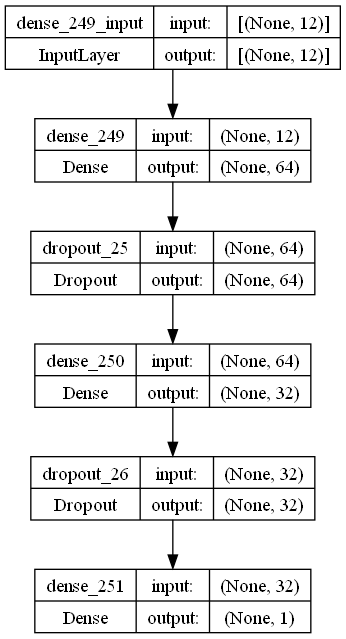

In [148]:
# Model 4
# Three dense layers with dropout
model4 = Sequential()
model4.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model4.add(Dropout(0.5))
model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(1, activation='sigmoid'))

model4.summary()
plot_model(model4, to_file='model_architecture4.png', show_shapes=True)

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_252 (Dense)           (None, 64)                832       
                                                                 
 batch_normalization_15 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_27 (Dropout)        (None, 64)                0         
                                                                 
 dense_253 (Dense)           (None, 64)                4160      
                                                                 
 batch_normalization_16 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_28 (Dropout)        (None, 64)              

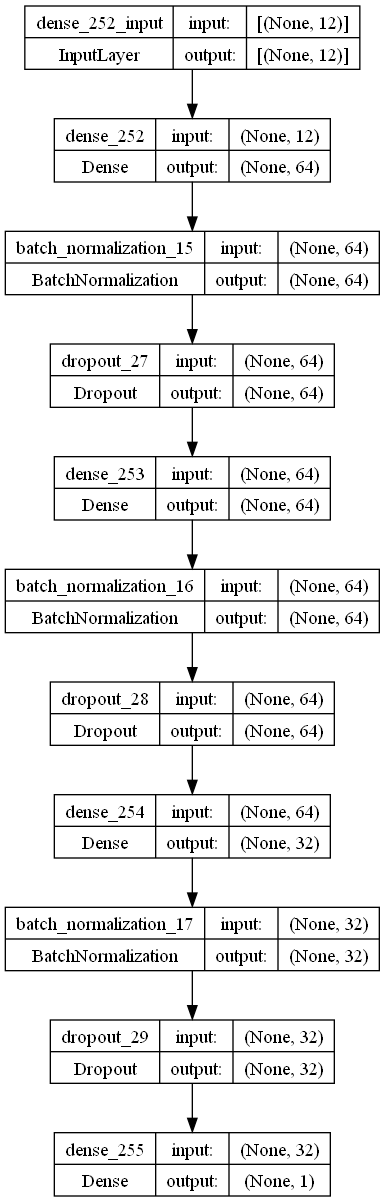

In [149]:
# Model 5
# Four dense layers with dropout and batch normalisation
model5 = Sequential()
model5.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))
model5.add(Dense(64, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))
model5.add(Dense(32, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))
model5.add(Dense(1, activation='sigmoid'))

model5.summary()
plot_model(model5, to_file='model_architecture5.png', show_shapes=True)

Training model 1
Epoch 1/100
90/90 [==============================] - 1s 2ms/step - loss: 0.2456 - accuracy: 0.9779 - val_loss: 0.1229 - val_accuracy: 0.9918
Epoch 2/100
90/90 [==============================] - 0s 1ms/step - loss: 0.0886 - accuracy: 0.9909 - val_loss: 0.0639 - val_accuracy: 0.9935
Epoch 3/100
90/90 [==============================] - 0s 1ms/step - loss: 0.0542 - accuracy: 0.9926 - val_loss: 0.0439 - val_accuracy: 0.9967
Epoch 4/100
90/90 [==============================] - 0s 1ms/step - loss: 0.0409 - accuracy: 0.9937 - val_loss: 0.0350 - val_accuracy: 0.9967
Epoch 5/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0340 - accuracy: 0.9947 - val_loss: 0.0304 - val_accuracy: 0.9967
Epoch 6/100
90/90 [==============================] - 0s 1ms/step - loss: 0.0300 - accuracy: 0.9947 - val_loss: 0.0275 - val_accuracy: 0.9967
Epoch 7/100
90/90 [==============================] - 0s 1ms/step - loss: 0.0273 - accuracy: 0.9951 - val_loss: 0.0256 - val_accuracy: 0.9

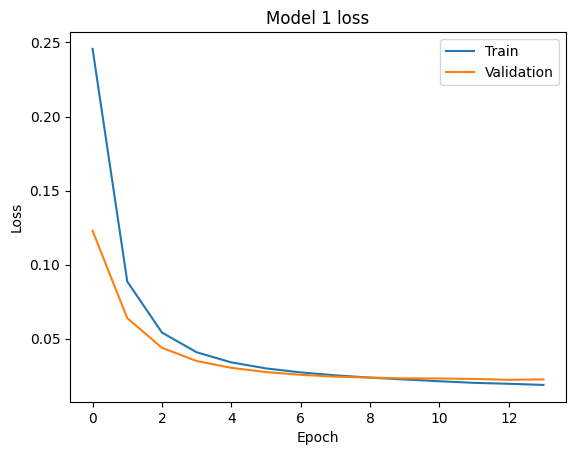

Training model 2
Epoch 1/100
90/90 [==============================] - 1s 6ms/step - loss: 0.2601 - accuracy: 0.9314 - val_loss: 0.0670 - val_accuracy: 0.9918
Epoch 2/100
90/90 [==============================] - 0s 1ms/step - loss: 0.0466 - accuracy: 0.9916 - val_loss: 0.0344 - val_accuracy: 0.9951
Epoch 3/100
90/90 [==============================] - 0s 1ms/step - loss: 0.0314 - accuracy: 0.9940 - val_loss: 0.0269 - val_accuracy: 0.9967
Epoch 4/100
90/90 [==============================] - 0s 1ms/step - loss: 0.0269 - accuracy: 0.9947 - val_loss: 0.0245 - val_accuracy: 0.9984
Epoch 5/100
90/90 [==============================] - 0s 1ms/step - loss: 0.0235 - accuracy: 0.9954 - val_loss: 0.0237 - val_accuracy: 0.9984
Epoch 6/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0211 - accuracy: 0.9954 - val_loss: 0.0231 - val_accuracy: 0.9984
Epoch 7/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 0.9947 - val_loss: 0.0232 - val_accuracy: 0.9

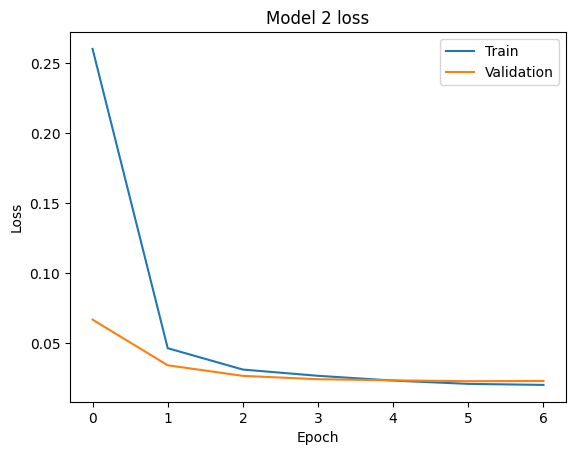

Training model 3
Epoch 1/100
90/90 [==============================] - 1s 3ms/step - loss: 0.1579 - accuracy: 0.9713 - val_loss: 0.0284 - val_accuracy: 0.9951
Epoch 2/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0313 - accuracy: 0.9926 - val_loss: 0.0231 - val_accuracy: 0.9967
Epoch 3/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0254 - accuracy: 0.9944 - val_loss: 0.0214 - val_accuracy: 0.9984
Epoch 4/100
90/90 [==============================] - 0s 4ms/step - loss: 0.0208 - accuracy: 0.9954 - val_loss: 0.0216 - val_accuracy: 0.9984
Epoch 4: early stopping


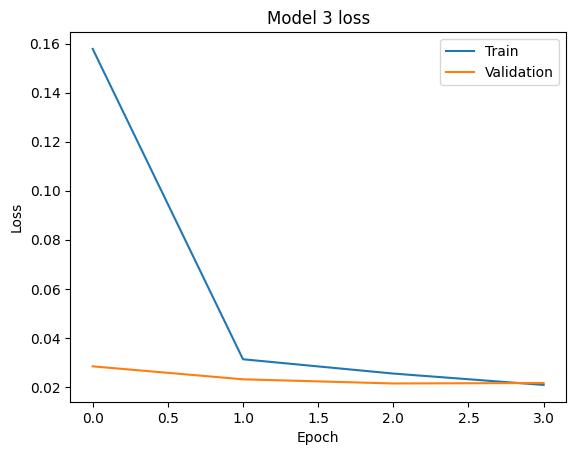

Training model 4
Epoch 1/100
90/90 [==============================] - 2s 5ms/step - loss: 0.3887 - accuracy: 0.8550 - val_loss: 0.1271 - val_accuracy: 0.9869
Epoch 2/100
90/90 [==============================] - 0s 3ms/step - loss: 0.1460 - accuracy: 0.9569 - val_loss: 0.0467 - val_accuracy: 0.9935
Epoch 3/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0877 - accuracy: 0.9769 - val_loss: 0.0330 - val_accuracy: 0.9951
Epoch 4/100
90/90 [==============================] - 0s 4ms/step - loss: 0.0657 - accuracy: 0.9842 - val_loss: 0.0284 - val_accuracy: 0.9951
Epoch 5/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0581 - accuracy: 0.9832 - val_loss: 0.0270 - val_accuracy: 0.9967
Epoch 6/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0487 - accuracy: 0.9870 - val_loss: 0.0260 - val_accuracy: 0.9967
Epoch 7/100
90/90 [==============================] - 0s 4ms/step - loss: 0.0430 - accuracy: 0.9909 - val_loss: 0.0262 - val_accuracy: 0.9

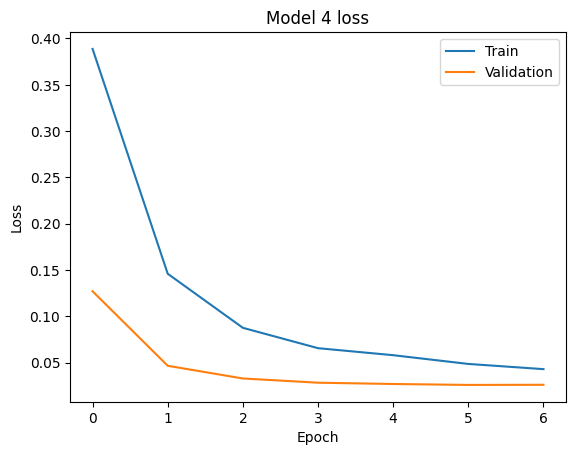

Training model 5
Epoch 1/100
90/90 [==============================] - 3s 6ms/step - loss: 0.6873 - accuracy: 0.6730 - val_loss: 0.2805 - val_accuracy: 0.9804
Epoch 2/100
90/90 [==============================] - 0s 3ms/step - loss: 0.3312 - accuracy: 0.8796 - val_loss: 0.1066 - val_accuracy: 0.9869
Epoch 3/100
90/90 [==============================] - 0s 3ms/step - loss: 0.1974 - accuracy: 0.9503 - val_loss: 0.0629 - val_accuracy: 0.9918
Epoch 4/100
90/90 [==============================] - 0s 3ms/step - loss: 0.1486 - accuracy: 0.9636 - val_loss: 0.0467 - val_accuracy: 0.9918
Epoch 5/100
90/90 [==============================] - 0s 3ms/step - loss: 0.1184 - accuracy: 0.9688 - val_loss: 0.0343 - val_accuracy: 0.9951
Epoch 6/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0998 - accuracy: 0.9765 - val_loss: 0.0285 - val_accuracy: 0.9951
Epoch 7/100
90/90 [==============================] - 0s 4ms/step - loss: 0.0965 - accuracy: 0.9765 - val_loss: 0.0234 - val_accuracy: 0.9

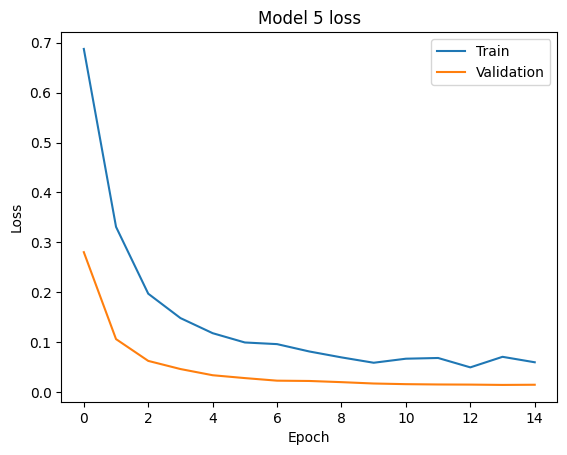

In [150]:
models = [model1, model2, model3, model4, model5]
best_validation_accuracy = 0.0

# Compile and train models
for i, model in enumerate(models, 1):
    print(f'Training model {i}')
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[es])
    
    # Retrieve the validation accuracy from history
    val_accuracy = history.history['val_accuracy'][-1]
    
    # Check if the current model has the highest validation accuracy
    if val_accuracy > best_validation_accuracy:
        best_model = model
        best_validation_accuracy = val_accuracy
        best_model_index = i

    # Plot training/validation loss
    plt.figure(i)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model {i} loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [151]:
# Print the architecture of the best model
best_model.summary()

# Display the best model and its validation accuracy
print(f"The best model is: Model {best_model_index} with validation accuracy: {best_validation_accuracy}")

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_240 (Dense)           (None, 64)                832       
                                                                 
 dense_241 (Dense)           (None, 1)                 65        
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________
The best model is: Model 1 with validation accuracy: 0.9983659982681274


- Model 1 has a validation accuracy of 0.9983659982681274, it indicates that the model performs very well on the validation set. A high validation accuracy suggests that the model is able to make accurate predictions on unseen data, which is a desirable characteristic.

## (d) Model Tuning
- Hyperparameters tuning

In [152]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import random


# Create an empty DataFrame
results_table = pd.DataFrame(columns=['Activation Function', 'Learning Rate', 'Optimizer', 'Accuracy'])

# Define the hyperparameter values
activations = ['relu', 'sigmoid', 'tanh']
learning_rates = [0.1, 0.01, 0.001]
optimizers = ['adam', 'sgd', 'rmsprop']

# Set the number of combinations to evaluate
num_evaluations = 10

# Perform random search
for _ in range(num_evaluations):
    # Randomly select hyperparameters
    activation = random.choice(activations)
    learning_rate = random.choice(learning_rates)
    optimizer = random.choice(optimizers)

    # Create a new instance of the model
    model = tf.keras.Sequential([
        layers.Dense(64, activation=activation, input_shape=(X_train.shape[1],)),
        layers.Dense(32, activation=activation),
        layers.Dense(16, activation=activation),
        layers.Dense(1, activation='sigmoid')
    ])
    # Compile the model with the current hyperparameters
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Evaluate the model on the test set
    _, accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Record the results in the table
    results_table = pd.concat([results_table, pd.DataFrame([[activation, learning_rate, optimizer, accuracy]],
                                                           columns=['Activation Function', 'Learning Rate', 'Optimizer', 'Accuracy'])], ignore_index=True)
    
    # Print the results in a table
print(results_table)
print()

# Sort the results table by accuracy in descending order
results_table_sorted = results_table.sort_values(by='Accuracy', ascending=False)

# Retrieve the best hyperparameters (top row)
best_hyperparameters = results_table_sorted.iloc[0]

# Display the best hyperparameters
print("Best Hyperparameters:")
print("Activation Function:", best_hyperparameters['Activation Function'])
print("Learning Rate:", best_hyperparameters['Learning Rate'])
print("Optimizer:", best_hyperparameters['Optimizer'])
print("Accuracy:", best_hyperparameters['Accuracy'])

  Activation Function  Learning Rate Optimizer  Accuracy
0             sigmoid           0.01      adam  0.995106
1                relu           0.01       sgd  0.991843
2                tanh           0.10   rmsprop  0.995106
3             sigmoid           0.01      adam  0.995106
4                tanh           0.01      adam  0.998369
5                relu           0.10      adam  0.995106
6                tanh           0.10      adam  0.998369
7                relu           0.10       sgd  0.990212
8             sigmoid           0.10   rmsprop  0.995106
9                tanh           0.01      adam  0.996737

Best Hyperparameters:
Activation Function: tanh
Learning Rate: 0.01
Optimizer: adam
Accuracy: 0.9983686804771423


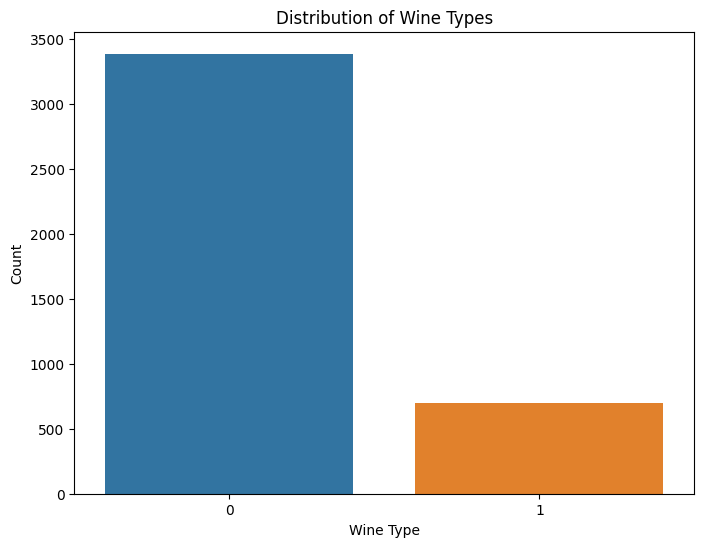

In [153]:
# Plot histogram of target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='type', data=wine)
plt.title('Distribution of Wine Types')
plt.xlabel('Wine Type')
plt.ylabel('Count')
plt.show()

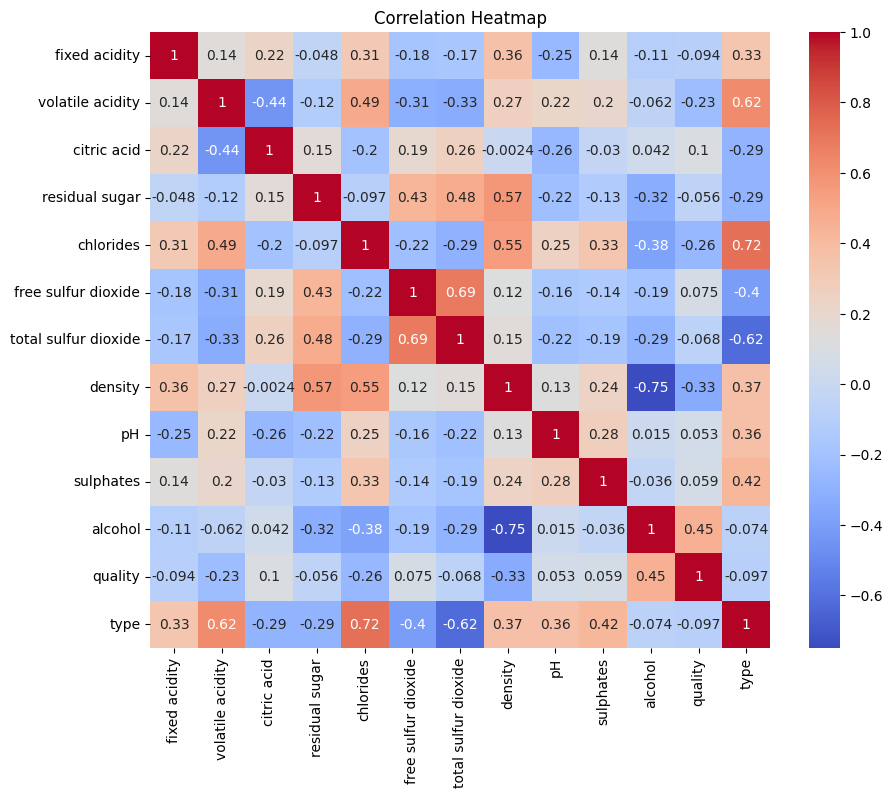

In [154]:
# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(wine.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## (e) Model evaluation
- Displaying confusion matrix and ROC curve

In [155]:
# Predict the test set results
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5)

20/20 [==============================] - 0s 2ms/step


In [156]:
# Compute and print the performance metrics
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))

Test accuracy: 0.9967373572593801
Precision: 1.0
Recall: 0.9789473684210527
F1 Score: 0.9893617021276596
AUC: 0.9894736842105263


In [157]:
# Compute and print the performance metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\n")
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[518   0]
 [  2  93]]


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       518
           1       1.00      0.98      0.99        95

    accuracy                           1.00       613
   macro avg       1.00      0.99      0.99       613
weighted avg       1.00      1.00      1.00       613



Accuracy Score:
0.9967373572593801


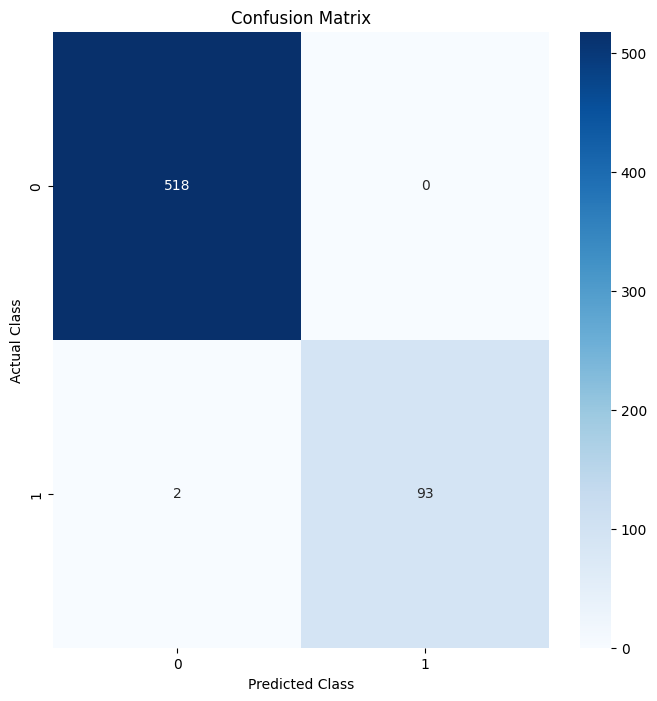

In [158]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel("Predicted Class")
plt.ylabel('Actual Class')
plt.show()

In [159]:
# Calculate the probabilities of the predictions
y_test_prob = best_model.predict(X_test)

20/20 [==============================] - 0s 1ms/step


In [160]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

In [161]:
# Calculate AUC score
auc_score = roc_auc_score(y_test, y_test_prob)

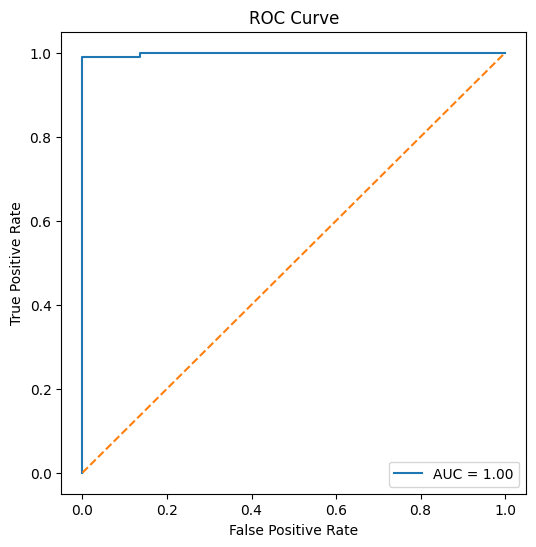

In [162]:
# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()